In [136]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Dense, Add, UpSampling2D, Reshape, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import os
import time

In [151]:
ds = tfds.load('div2k/bicubic_x4', shuffle_files=True)

In [138]:
def resize_and_normalize(sample):
    sample['hr'] = tf.image.resize(sample['hr'], [512, 512])
    sample['lr'] = tf.image.resize(sample['lr'], [256, 256])

    sample['hr'] = tf.cast(sample['hr'], tf.float32) / 255.0
    sample['lr'] = tf.cast(sample['lr'], tf.float32) / 255.0

    return sample


ds_train_resized = ds["train"].map(resize_and_normalize)
ds_train_batched = ds_train_resized.batch(2)

ds_valid_resized = ds["validation"].map(resize_and_normalize)
ds_valid_batched = ds_valid_resized.batch(2)


In [153]:
LR_SHAPE = (256,256,3)
HR_SHAPE = (512,512,3)

def make_generator_model():

    input = Input(shape=LR_SHAPE)

    x = Reshape(LR_SHAPE)(input)

    x = Conv2DTranspose(256, 2, strides=(1,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(128, 2, strides=(1,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, 2, strides=(1,1), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, 2, strides=(2,2), padding="same")(x)
    


    return Model(input, x)

gen_model = make_generator_model()
gen_model.summary()



Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 reshape_17 (Reshape)        (None, 256, 256, 3)       0         
                                                                 
 conv2d_transpose_59 (Conv2D  (None, 256, 256, 256)    3328      
 Transpose)                                                      
                                                                 
 batch_normalization_57 (Bat  (None, 256, 256, 256)    1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_83 (LeakyReLU)  (None, 256, 256, 256)     0         
                                                                 
 conv2d_transpose_60 (Conv2D  (None, 256, 256, 128)    131

In [140]:
def make_discriminator_model():
    input = Input(shape=HR_SHAPE)
    x = Conv2D(32, (5,5), strides=(2,2), padding="same", input_shape=HR_SHAPE)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)


    x = Conv2D(32, (5,5), strides=(2,2), padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)

    return Model(input, x)

discriminator_model = make_discriminator_model()
discriminator_model.summary()



Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 256, 256, 32)      2432      
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 256, 256, 32)      0         
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 flatten_10 (Flatten)        (None, 524288)            0         
                                                                 
 dense_10 (Dense)            (None, 1)                 524

(256, 256, 3)


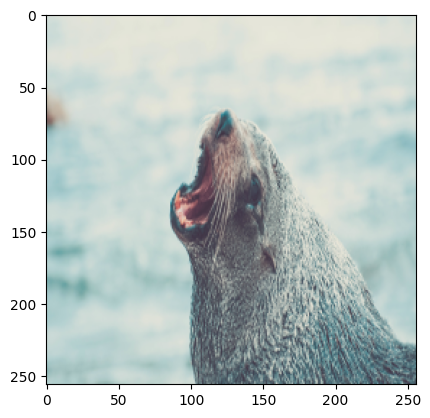

In [141]:
low_res_test_image = next(iter(ds_train_batched))['lr'][0]
plt.imshow(low_res_test_image)
print(low_res_test_image.shape)


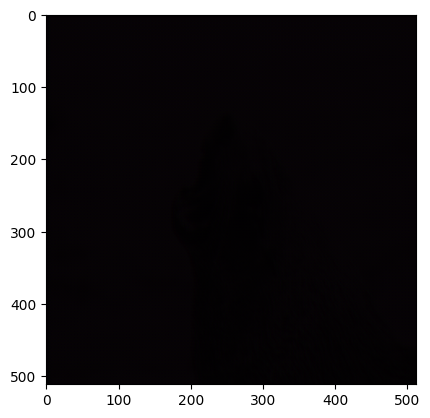

In [142]:
example_gen_image = gen_model(np.expand_dims(low_res_test_image, axis=0))[0]
plt.imshow(example_gen_image)

In [143]:
from tensorflow.keras.applications import VGG19

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def content_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# def perceptual_loss(y_true, y_pred):
#     vgg = VGG19(include_top=False, weights='imagenet', input_shape=HR_SHAPE)
#     vgg.trainable = False
#     for layer in vgg.layers:
#         layer.trainable = False
#     model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
#     model.trainable = False
#     return tf.reduce_mean(tf.square(model(y_true) - model(y_pred)))

def generator_loss(fake_output, real_images, fake_images):
    adv_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    #pct_loss = perceptual_loss(real_images, fake_images)
    cont_loss = content_loss(real_images, fake_images)
    return 0.6*adv_loss + 0.4 * cont_loss 


generator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)



In [144]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=gen_model,
                                 discriminator=discriminator_model)


In [145]:
EPOCHS = 5

def train_step(lr_image_batch, hr_image_batch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images = gen_model(lr_image_batch, training=True)
        # val_gen_images = gen_model(val_lr_image_batch, training=False)



        real_output = discriminator_model(hr_image_batch, training=True)
        fake_output = discriminator_model(gen_images, training=True)
        # real_val_output = discriminator_model(val_hr_image_batch, training=False)
        # fake_val_output = discriminator_model(val_gen_images, training=False)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output, hr_image_batch, gen_images)
        # val_gen_loss = generator_loss(fake_val_output, val_hr_image_batch, val_gen_images)



        print("gen_loss: ", gen_loss.numpy())
        

    gradient_gen = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    gradient_disc = disc_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_gen, gen_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_disc, discriminator_model.trainable_variables))


In [146]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for n, iter_item in enumerate(iter(dataset):
            hr_image_batch = iter_item[0]["hr"]
            lr_image_batch = iter_item[0]["lr"]
            # val_hr_image_batch = iter_item[1]["hr"]
            # val_lr_image_batch = iter_item[1]["lr"]

            train_step(lr_image_batch, hr_image_batch)
            print(n+1, "batches complete in epoch", epoch)
        checkpoint.save(checkpoint_prefix)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))





In [147]:
train(ds_train_batched, ds_valid_batched, 2)

gen_loss:  0.68400306 val_loss 0.5034207
1 batches complete in epoch 0
gen_loss:  0.55339044 val_loss 0.48763454
2 batches complete in epoch 0
gen_loss:  0.7455833 val_loss 0.487282
3 batches complete in epoch 0
gen_loss:  1.269745 val_loss 0.5111552
4 batches complete in epoch 0
gen_loss:  1.6863735 val_loss 0.50800127
5 batches complete in epoch 0
gen_loss:  1.6302056 val_loss 0.4970643
6 batches complete in epoch 0
gen_loss:  1.67062 val_loss 0.50444734
7 batches complete in epoch 0
gen_loss:  1.5369201 val_loss 0.4923457
8 batches complete in epoch 0
gen_loss:  1.5433433 val_loss 0.542338
9 batches complete in epoch 0
gen_loss:  1.589283 val_loss 0.5194839
10 batches complete in epoch 0
gen_loss:  1.4574003 val_loss 0.5271379
11 batches complete in epoch 0
gen_loss:  2.3860688 val_loss 0.5341359
12 batches complete in epoch 0
gen_loss:  2.9433773 val_loss 0.5558715
13 batches complete in epoch 0
gen_loss:  2.331064 val_loss 0.522072
14 batches complete in epoch 0
gen_loss:  1.98913

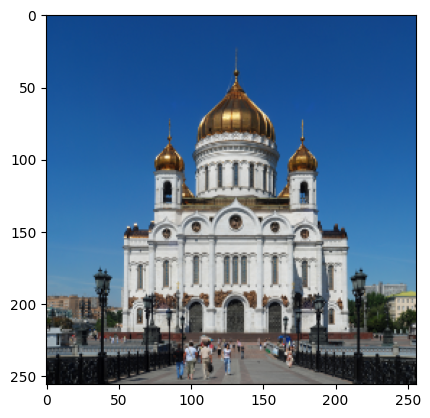

In [148]:
example_image = next(iter(ds_valid_batched))["lr"][0]
plt.imshow(example_image)

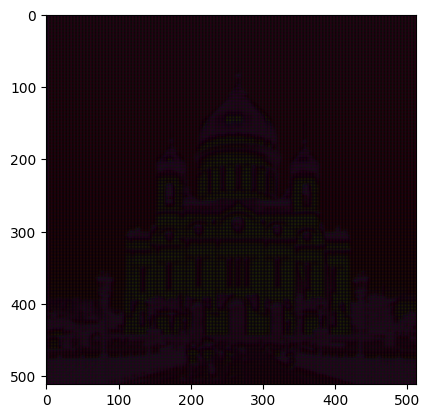

In [149]:
test_gen_image = gen_model(tf.expand_dims(example_image, axis=0), training=False)[0]

plt.imshow(test_gen_image)